<a href="https://colab.research.google.com/github/matand380/DNN_final_project_2024/blob/main/DNN_final_project_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Deep Learning - Final Project** 🖥

## Team Information
- **Course:** Introduction to Deep Learning

- **Semester:** Fall 2024

- **Lectrurer:** Dr. Moshe Butman

- **Institution:** The College of Management Academic Studies

- **Team Members:** Eviatar Didon 313205387, Matan Drabkin 201416690

## Project Overview

### Objective

This project centers around the application of deep learning techniques to classify chest X-ray images into distinct categories,

with a specific emphasis on differentiating between healthy cases and those diagnosed with pneumonia.

The dataset for training and evaluation includes a total of 5863 X-ray images, categorized as follows:

- A. **Healthy**
- B. **Pneumonia**
  - Bacterial Pneumonia
  - Viral Pneumonia



# Kaggle Dataset Downloading and Unzipping

### Prerequisites

Ensure that the necessary packages (`kaggle`) are installed before running the code. Use the following command to install the `kaggle` package:

In [7]:
!pip install kaggle

### Uploading Kaggle API Key

Use the file picker to upload your Kaggle API key:


In [8]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


### Move API Key to the Right Directory

After uploading the API key, please ensure that Kaggle can use the API key for authentication.

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Download and Unzip Kaggle Dataset

download the Chest X-ray Pneumonia dataset and unzip it in the Colab environment:

In [10]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# Binary classification - Healthy vs Pneumonia

## Preprocessing - Data augmentation and normalization

In [11]:
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Paths
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

## Reorganization of the data

In the original data there's only 16 samples for the validation set. At the first training we got overfitting on the validation so we reorganize the samples in order to get more balanced data

In [12]:


# We load all file paths in the training and validation directories and combine them
all_train_files = []
for root, dirs, files in os.walk(train_dir):
    all_train_files.extend([os.path.join(root, file) for file in files])

all_val_files = []
for root, dirs, files in os.walk(val_dir):
    all_val_files.extend([os.path.join(root, file) for file in files])

all_files = all_train_files + all_val_files

labels = [os.path.basename(os.path.dirname(file)) for file in all_files]

# Split the into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=42, stratify=labels
)

# DataGenerators for training and validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary'
)

# Test generator for evaluation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary'
)

num_val_images = len(val_files)
print(f"Number of images in the validation set: {num_val_images}")

num_train_images = len(train_files)
print(f"Number of images in the validation set: {num_train_images}")



Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.
Number of images in the validation set: 1047
Number of images in the validation set: 4185


## Build the model and train it


we tried setting the lreaning rate to 0.01 but we got worse results than 0.001 (which is the default for Adam optimizer)

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam


model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #used defualt lr = 0.001

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_2 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_3 (Bat  (None, 29, 29, 64)       

In [ ]:
print("Number of training samples:", train_generator.samples)


Number of training samples: 4185


In [14]:
from google.colab import drive

drive.mount('/content/gdrive')

drive_path = '/content/gdrive/My Drive/Colab Notebooks/DNN_final_project_2024'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
# Train the model

from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'{drive_path}/best_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.8499

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 95s 709ms/step - loss: 0.6402 - accuracy: 0.8499 - val_loss: 1.2606 - val_accuracy: 0.7421
Epoch 2/10
131/131 [==============================] - 88s 674ms/step - loss: 0.2545 - accuracy: 0.8982 - val_loss: 2.0925 - val_accuracy: 0.7421
Epoch 3/10
131/131 [==============================] - 93s 713ms/step - loss: 0.2431 - accuracy: 0.9027 - val_loss: 1.8214 - val_accuracy: 0.7421
Epoch 4/10
131/131 [==============================] - 97s 737ms/step - loss: 0.2244 - accuracy: 0.9142 - val_loss: 0.8538 - val_accuracy: 0.7822
Epoch 5/10
131/131 [==============================] - 85s 651ms/step - loss: 0.2232 - accuracy: 0.9140 - val_loss: 0.1749 - val_accuracy: 0.9456
Epoch 6/10
131/131 [==============================] - 95s 725ms/step - loss: 0.2088 - accuracy: 0.9231 - val_loss: 0.1719 - val_accuracy: 0.9322
Epoch 7/10
131/131 [==============================] - 93s 708ms/step - loss: 0.2015 - accuracy: 0.9195 - val_loss: 0.2331 - val_accuracy: 0.8

In [16]:
print("Training Accuracy:", round(history.history['accuracy'][-1], 3))
print("Training Loss:", round(history.history['loss'][-1], 3))
print("Validation Accuracy:", round(history.history['val_accuracy'][-1], 3))
print("Validation Loss:", round(history.history['val_loss'][-1], 3))

Training Accuracy: 0.931
Training Loss: 0.187
Validation Accuracy: 0.899
Validation Loss: 0.239


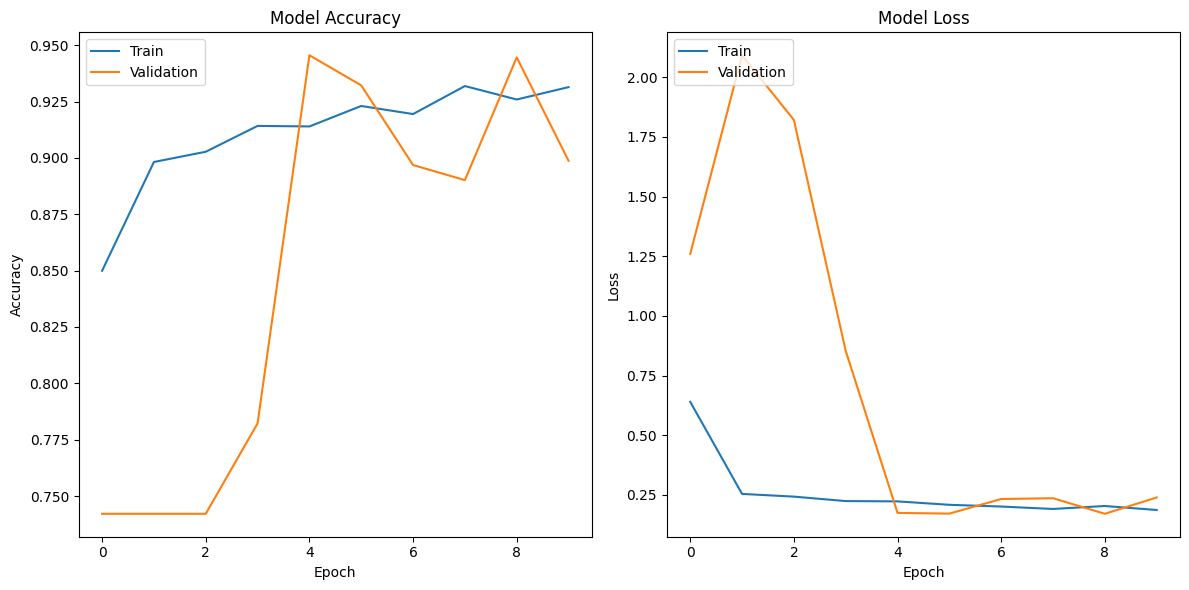

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


### Evaluate the model

In [18]:
from keras.models import load_model

# Load the binary model
binary_model = load_model(f'{drive_path}/best_model.h5')
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


test_loss, test_accuracy = binary_model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

20/20 [==============================] - 6s 283ms/step - loss: 0.3171 - accuracy: 0.8974
Test Loss: 0.3171
Test Accuracy: 0.8974


In [19]:
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Print the predictions
print("Predictions:", predictions)

predicted_classes = (predictions > 0.5).astype(int)
print("Predicted Classes:", predicted_classes)

20/20 [==============================] - 8s 403ms/step
Predictions: [[0.999768  ]
 [0.15361956]
 [0.9709183 ]
 [0.17611644]
 [0.9960438 ]
 [0.9235829 ]
 [0.01007206]
 [0.7711264 ]
 [0.00960417]
 [0.17261034]
 [0.91350853]
 [0.99730486]
 [0.15031153]
 [0.9575089 ]
 [0.01811769]
 [0.99994755]
 [0.03050642]
 [0.99050856]
 [0.01591041]
 [0.9999749 ]
 [0.7269233 ]
 [0.99589586]
 [0.9485162 ]
 [0.9971407 ]
 [0.11165433]
 [0.06507197]
 [0.9794861 ]
 [0.9998882 ]
 [0.03092581]
 [0.00589691]
 [0.97804123]
 [0.8998884 ]
 [0.01168271]
 [0.964854  ]
 [0.9881028 ]
 [0.93114483]
 [0.7703709 ]
 [0.97822696]
 [0.01060673]
 [0.99848056]
 [0.9948536 ]
 [0.034573  ]
 [0.02462548]
 [0.0212467 ]
 [0.05432178]
 [0.0063367 ]
 [0.00528635]
 [0.98484886]
 [0.01379266]
 [0.9838977 ]
 [0.03237827]
 [0.8610592 ]
 [0.02696396]
 [0.94237226]
 [0.95369816]
 [0.9991422 ]
 [0.00587448]
 [0.9875864 ]
 [0.4176031 ]
 [0.02535659]
 [0.20338358]
 [0.9965213 ]
 [0.9281567 ]
 [0.05927869]
 [0.99641764]
 [0.92266816]
 [0.0032

# Multi-class classification

## Modify data preparation

In [ ]:
# DataGenerators for training and validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test generator for evaluation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)